In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
def plot_predictions(test,predicted):
    plt.plot(test, color='green',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [ ]:
#Getting the data
dataset = pd.read_csv('/content/IBM stock price data.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [ ]:
dataset=dataset.drop(['Name'], axis=1)

In [ ]:
# Checking for missing values
dataset.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [ ]:
# Dividing the data into train and test dataset
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

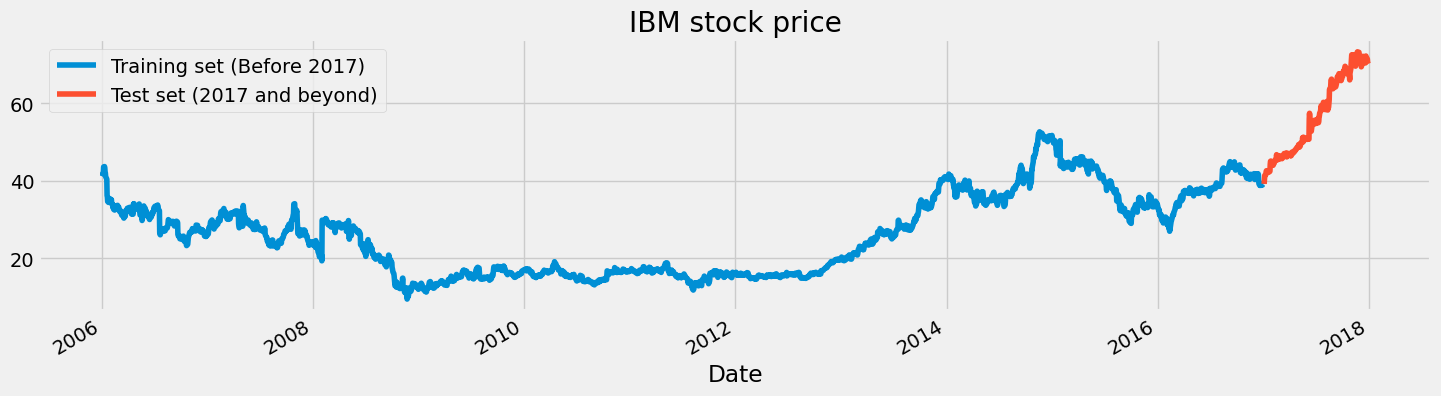

In [ ]:
# We have chosen 'High' attribute for prices.
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# Long Short Term Memory (LSTM)

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 14s 101ms/step - loss: 0.0153
Epoch 2/50
85/85 [==============================] - 9s 108ms/step - loss: 0.0066
Epoch 3/50
85/85 [==============================] - 8s 97ms/step - loss: 0.0055
Epoch 4/50
85/85 [==============================] - 8s 92ms/step - loss: 0.0049
Epoch 5/50
85/85 [==============================] - 8s 97ms/step - loss: 0.0041
Epoch 6/50
85/85 [==============================] - 8s 98ms/step - loss: 0.0039
Epoch 7/50
85/85 [==============================] - 8s 90ms/step - loss: 0.0035
Epoch 8/50
85/85 [==============================] - 9s 100ms/step - loss: 0.0032
Epoch 9/50
85/85 [==============================] - 10s 120ms/step - loss: 0.0032
Epoch 10/50
85/85 [==============================] - 8s 98ms/step - loss: 0.0030
Epoch 11/50
85/85 [==============================] - 11s 126ms/step - loss: 0.0027
Epoch 12/50
85/85 [==============================] - 8s 98ms/step - loss: 0.0025
Epoch 13/50
85/85 [==========

In [ ]:
# Same as training set has been done for 1st 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 23ms/step


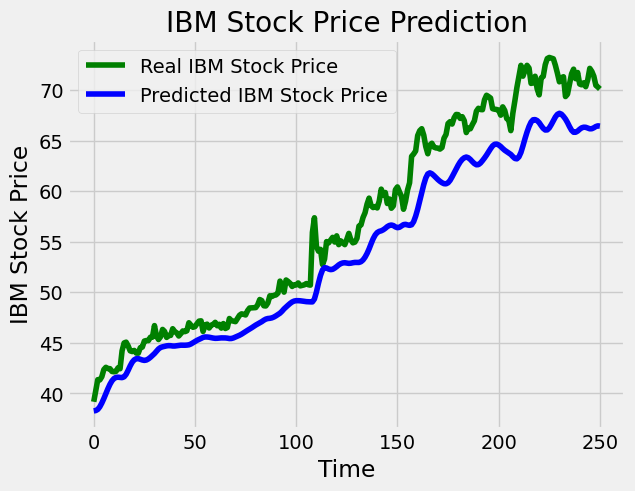

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 3.5545309899725845.


# Gated Recurrent units (GRU)

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - 9s 162ms/step - loss: 0.0868
Epoch 2/50
19/19 [==============================] - 3s 162ms/step - loss: 0.0356
Epoch 3/50
19/19 [==============================] - 3s 161ms/step - loss: 0.0129
Epoch 4/50
19/19 [==============================] - 4s 189ms/step - loss: 0.0036
Epoch 5/50
19/19 [==============================] - 3s 157ms/step - loss: 0.0032
Epoch 6/50
19/19 [==============================] - 3s 160ms/step - loss: 0.0030
Epoch 7/50
19/19 [==============================] - 4s 193ms/step - loss: 0.0030
Epoch 8/50
19/19 [==============================] - 3s 161ms/step - loss: 0.0027
Epoch 9/50
19/19 [==============================] - 3s 162ms/step - loss: 0.0026
Epoch 10/50
19/19 [==============================] - 3s 159ms/step - loss: 0.0027
Epoch 11/50
19/19 [==============================] - 4s 198ms/step - loss: 0.0028
Epoch 12/50
19/19 [==============================] - 3s 161ms/step - loss: 0.0025
Epoch 13/50
19/19 [=================

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 [==============================] - 1s 19ms/step


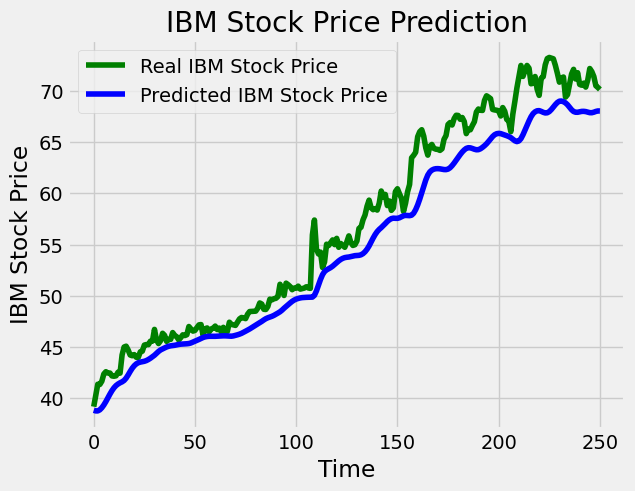

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)


In [ ]:
#Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 2.7456602946066355.
